In [1]:
import numpy as np
from scipy import constants as c
from scipy import special as sp
from iminuit import Minuit, cost
from argparse import Namespace
import pandas as pd
import os
import matplotlib.pyplot as plt
import h5py as h5
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from IPython.display import display, Math

C:\Users\ricca\AppData\Local\Temp\ipykernel_18252\2885714771.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
KB = c.Boltzmann
hbar = c.Planck

In [13]:
def read_files(dir = 'F:\\LabIV\\QTLab2324\\IRdetection\\Instruments\\Test_data\\data_19_02_set1\\T_170\\'):

    dictionaries = []

    for (i,filename) in enumerate(os.listdir(dir)):
        my_source = dir + filename
        with h5.File(my_source, 'r') as r:
            group = r.require_group(name='raw_data')
            dic = dict()
            for c in group.items():
                dic[c[0]] = c[1][:]
        dictionaries.append(dic)
    return dictionaries

In [14]:
dfs = read_files()

In [15]:
F = dfs[3]['f']
I = dfs[3]['i']
Q = dfs[3]['q']
S21 = np.sqrt(I**2 + Q**2)

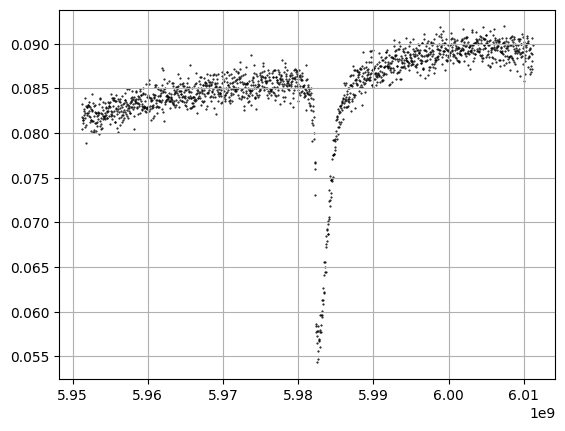

In [16]:
plt.scatter(F, S21, s=1, marker='.', color='black')
plt.grid()

In [413]:
x, y = find_peaks(-S21, -0.02)
x_min = F[x[np.argmin(y['peak_heights'])]]
y_min = -max(y['peak_heights'])

Normalize and center data about minimum

In [426]:
S21 = [(x - y_min) / (max(S21) - y_min) for x in S21]
F = (F-x_min)/x_min

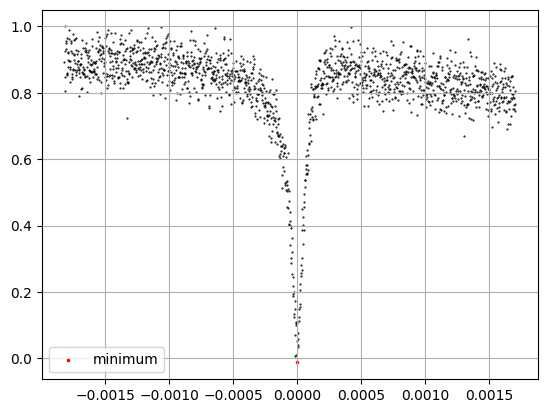

In [428]:
plt.scatter(F, S21, s=1, marker='.', color='black')
plt.scatter(0, min(S21), s=10, marker='.', color='red', label='minimum')
plt.legend()
plt.grid()

Separating bg from resonance data + fitting bg with 1st order pol

In [527]:
condition = lambda x: (x<-0.001 or x>0.001)
idxs = [i for i,x in enumerate(F) if condition(x)]
F_bg = np.array([F[i] for i in idxs])
S21_bg = np.array([S21[i] for i in idxs])
F_res = np.array([F[i] for i,x in enumerate(F) if not condition(x)])
S21_res = np.array([S21[i] for i,x in enumerate(F) if not condition(x)])
params = np.polyfit(F, S21,1)
rms = np.sqrt(np.mean((np.polyval(params, F_bg)-S21_bg)**2))

Plot 

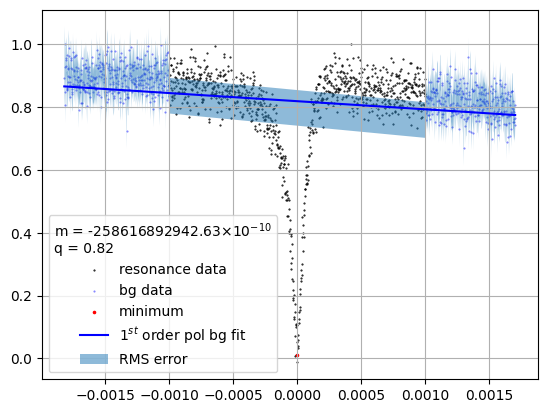

In [536]:
plt.scatter(F_res, S21_res, s=1, marker='.', color='black', label='resonance data')
plt.scatter(F_bg, S21_bg, marker='.', s=1, color='blue', alpha=0.5, label='bg data')
plt.scatter(0, y_min, s=10, marker='.', color='red', label='minimum')
plt.plot(F, np.polyval(params, F), color='blue',label='$1^{st}$ order pol bg fit')
plt.grid()
cond = lambda x: x in F_bg
plt.fill_between(F_bg, S21_bg+rms, S21_bg-rms, alpha=0.5, label='RMS error')
title = [f"m = {params[0]*1e10:.2f}"+r"$\times 10^{-10}$", f"q = {params[1]:.2f}"]
plt.legend(title = "\n".join(title))

Estimate FWHM (using res data only)

In [466]:
def FWHM(x,y):
    max_y = np.max(y)
    half_max_y = max_y / 2.0

    condition = lambda t: (t<=half_max_y*(1+0.01) or t>=half_max_y*(1-0.01))
    indices = [i for i,y in enumerate(y) if condition(y)]
    if len(indices) < 2:
        raise ValueError("Cannot find FWHM. The curve might not cross half of its maximum.")

    # Get corresponding x values
    x_half_max = [x[index] for index in indices]

    # Calculate FWHM
    return np.abs(x_half_max[-1] - x_half_max[0])

Initial parameters estimation

In [522]:
fwhm = FWHM(F_res, S21_res)
Q_tot = x_min/(fwhm*1e9)
Q_c = 3e3
phi0 = 0.02

In [523]:
def resonance_model(x, Q, Qc,phi0):
    return 1-Q/Qc*np.exp(1j*phi0)/(1+1j*((2*x*Q)))

def model(x, m, q, Q, Qc,phi0):
    par = np.array([m,q])
    pol = np.polyval(par, x)
    res = resonance_model(x, Q,Qc,phi0)
    return np.abs(res)*pol

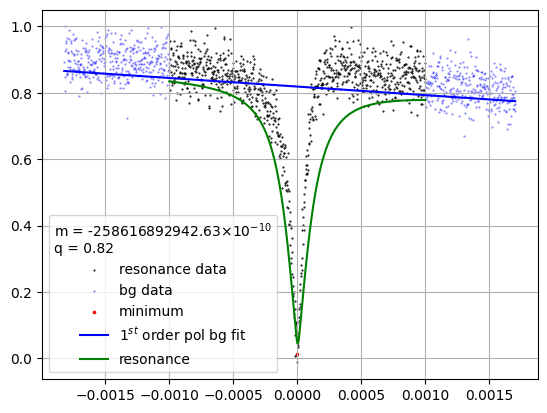

In [524]:
plt.scatter(F_res, S21_res, s=1, marker='.', color='black', label='resonance data')
plt.scatter(F_bg, S21_bg, marker='.', s=1, color='blue', alpha=0.5, label='bg data')
plt.scatter(0, y_min, s=10, marker='.', color='red', label='minimum')
plt.plot(F, np.polyval(params, F), color='blue',label='$1^{st}$ order pol bg fit')
plt.plot(F_res, model(F_res, params[0], params[1], Q_tot, Q_c, phi0), color='green',label='resonance')
plt.grid()
title = [f"m = {params[0]*1e10:.2f}"+r"$\times 10^{-10}$", f"q = {params[1]:.2f}"]

plt.legend(title = "\n".join(title))

In [537]:
p0 = [params[0], params[1], Q_tot, Q_c,phi0]
lsq = cost.LeastSquares(F_res,S21_res, rms, model)
m = Minuit(lsq, *p0)

In [538]:
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 644.2 (χ²/ndof = 0.7)      │              Nfcn = 195              │
│ EDM = 6.57e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ m    │    -22    │     4     │            │            │         │         │       │
│ 1 │ q    │  0.8708   │  0.0023   │            │            │         │         │       │
│ 2 │ Q    │  5.35e3   │  0.10e3   │            │            │         │         │       │
│ 3 │ Qc   │  5.18e3   │  0.16e3   │            │            │         │         │       │
│ 4 │ phi0 │  -0.092   │   0.006   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬─────────────────────────────────────────────────────────────┐
│      │           m           q           Q          Qc        phi0 │
├──────┼─────────────────────────────────────────────────────────────┤
│    m │        12.9     -483e-6          31          55     8.42e-3 │
│    q │     -483e-6     5.5e-06 -115.480e-3 -121.931e-3        1e-6 │
│    Q │          31 -115.480e-3    9.55e+03        11e3   -64.31e-3 │
│   Qc │          55 -121.931e-3        11e3    2.62e+04  -223.96e-3 │
│ phi0 │     8.42e-3        1e-6   -64.31e-3  -223.96e-3    4.22e-05 │
└──────┴─────────────────────────────────────────────────────────────┘

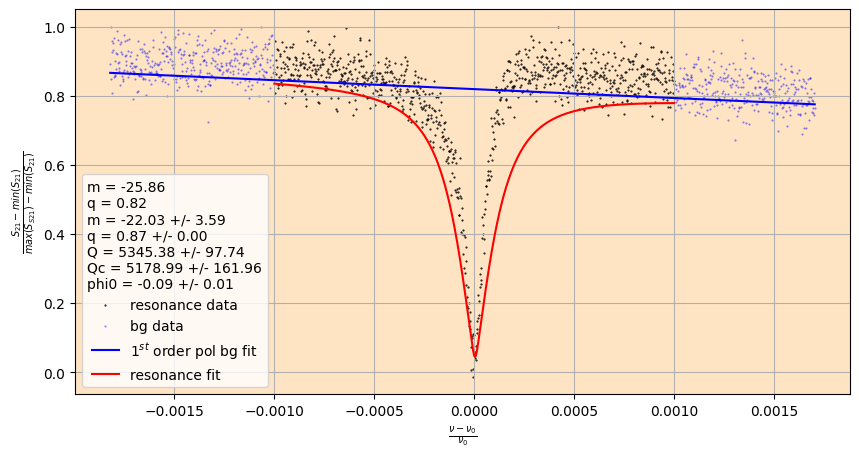

In [552]:
fig, axs = plt.subplots(figsize=(10,5))
axs.scatter(F_res, S21_res, s=1, marker='.', color='black', label='resonance data')
axs.scatter(F_bg, S21_bg, marker='.', s=1, color='blue', alpha=0.5, label='bg data')
axs.set_ylabel(r"$\frac{S_{21}-min(S_{21})}{max(S_{S21})-min(S_{21})}$")
axs.set_xlabel(r"$\frac{\nu-\nu_{0}}{\nu_{0}}$")
axs.plot(F, np.polyval(params, F), color='blue',label='$1^{st}$ order pol bg fit')
axs.plot(F_res, model(F_res, *p0), color='red',label='resonance fit')
axs.grid()
title = [f"m = {params[0]:.2f}", f"q = {params[1]:.2f}"]
for par in m.parameters:
            title.append(
                f"{par} = {m.values[par]:.2f} +/- {m.errors[par]:.2f}"
            )
axs.legend(title = "\n".join(title))
axs.set_facecolor('bisque')